In [ ]:
from brute_force_kinetic_DR_solver.ipynb import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.special import erf


%matplotlib inline

In [3]:
def dfMdv(v):
    return 1./np.sqrt(2*np.pi) * (-v) * np.exp(-0.5*v**2)

def dfBOTdv(v, v0, nb):
    return (1-nb)*dfMdv(v) + 0.5*nb*(dfMdv(v-v0)) + 0.5*nb*(dfMdv(v+v0))

def D_analytic(wr, wi, k0, v0, nb):
    vphi = wr/k0
    eps_v = 1e-3
    v = np.linspace(-12, vphi-eps_v,2048)
    integral = np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    v = np.linspace(vphi+eps_v,12, 2048)
    integral += np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    d = 1.-1./(k0**2) *integral
    # deforming contour under pole
    if wi == 0:
        d -= 1j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    elif wi<0:
        d -= 2j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    return d

def find_w_roots(k0, v0, nb, method = D_analytic):
    Wr = np.linspace(0,1.7,128)
    Wi = np.linspace(-0.3,0.3,101)

    D_arr = np.zeros((len(Wi), len(Wr)), dtype = complex)
    if (method == D_analytic):
        for i in range(len(Wi)):
            for j in range(len(Wr)):
                D_arr[i,j] = method(Wr[j], Wi[i], k0=k0, v0 = v0, nb = nb)
    elif (method == z_func):
        for i in range(len(Wi)):
            for j in range(len(Wr)):
                D_arr[i,j] = method(Wr[j], Wi[i], k0=k0)

    
    D_arr = np.abs(D_arr)
    zeros = np.where(D_arr<2*D_arr.min())
    return Wr[zeros[1]][:], Wi[zeros[0]][:]


In [24]:
def D_analytic(wr, wi, k0, v0, nb):
    vphi = wr/k0
    eps_v = 1e-3
    v = np.linspace(-12, vphi-eps_v,2048)
    integral = np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    v = np.linspace(vphi+eps_v,12, 2048)
    integral += np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    d = 1.-1./(k0**2) *integral
    # deforming contour under pole
    if wi == 0:
        d -= 1j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    elif wi<0:
        d -= 2j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    return d

def G(t, xi): #this is the exponential/1-xi function inside the integral
    return np.exp(-t**2)*1./(t-xi)

def Z_analytic(wr, wi, k0, vth):
    #vth=1 for electrons, can be different for ions?
    vphi = wr/k0
    eps_t = 1e-3
    xi = (wr+1j*wi)*1./(k0*np.sqrt(2)*vth)
    t = np.linspace(-12, vphi-eps_t,2048)
    integral = np.trapz(G(t, xi), t)
    t = np.linspace(vphi+eps_t,12, 2048)
    integral += np.trapz(G(t, xi), t)
    #pole contribution
    if wi == 0:
        sigma = 1
    elif wi<0:
        sigma = 2
    else:
        sigma = 0
    d = (integral+1j*np.pi*sigma*np.exp(-xi**2))*1./np.sqrt(np.pi)
    return d

def Z_prime(wr, wi, k0, vth):
    #formula for Z_prime in the notes
    xi = (wr+1j*wi)*1./(k0*np.sqrt(2)*vth)
    return -2-2*xi*Z_analytic(wr, wi, k0, vth)

def D_IAW_analytic(wr, wi, k0, vthi, mratio): #vthi is the ion thermal velocity as a fraction of the electron thermal velocity
    lambda_d = 1 #we are normalizing k0s to lambda_d
    wpe = 1 #we are scaling the time to the plasma frequency of electrons
    vthe = 1 #we are scaling the velocity to the thermal velocity of electrons, vthe = lambda_d/wpe
    wpi = wpe*1./np.sqrt(mratio)
    return 1-wpe*Z_prime(wr, wi, k0, lambda_d*wpe)*1./(np.sqrt(2)*(k0**2)*lambda_d*wpe)-wpi*Z_prime(wr, wi, k0, vthi)*1./(np.sqrt(2)*(k0**2)*vthi)

def find_w_roots(k0, vthi, mratio):
    Wr = np.linspace(0,1.7,128)
    Wi = np.linspace(-0.3,0.3,101)

    D_arr = np.zeros((len(Wi), len(Wr)), dtype = complex)
    for i in range(len(Wi)):
        for j in range(len(Wr)):
            D_arr[i,j] = D_IAW_analytic(Wr[j], Wi[i], k0=k0, vthi=vthi, mratio=mratio)
    
    D_arr = np.abs(D_arr)
    zeros = np.where(D_arr<2*D_arr.min())
    return Wr[zeros[1]][:], Wi[zeros[0]][:]

C:\Users\rayne\AppData\Local\Temp\ipykernel_26376\3076438550.py:35: RuntimeWarning: overflow encountered in exp
  d = (integral+1j*np.pi*sigma*np.exp(-xi**2))*1./np.sqrt(np.pi)
C:\Users\rayne\AppData\Local\Temp\ipykernel_26376\3076438550.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  d = (integral+1j*np.pi*sigma*np.exp(-xi**2))*1./np.sqrt(np.pi)


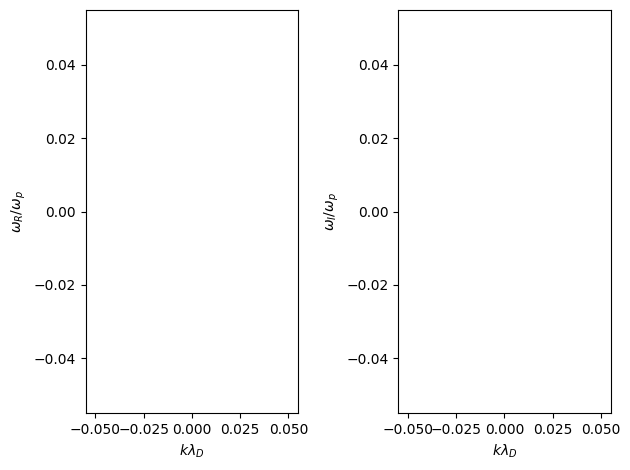

In [27]:
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel(r'$k\lambda_D$')
ax1.set_ylabel(r'$\omega_R/\omega_p$')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel(r'$k\lambda_D$')
ax2.set_ylabel(r'$\omega_I/\omega_p$')

k0s = np.linspace(0.1,0.7,14)

Ti = 1 #ion temperature as a fraction of electron temperature
mratio = 8*10**3 #ion mass as a fraction of electron mass
vthi = Ti*1./mratio

for k0 in k0s:
    Wrs, Wis = find_w_roots(k0, vthi, mratio)
    ax1.scatter(k0*np.ones(len(Wrs)), Wrs)
    ax2.scatter(k0*np.ones(len(Wis)), Wis)

plt.tight_layout()